In [138]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

In [116]:
#ResNet50
from torchvision.models import resnet50, ResNet50_Weights

In [140]:
#EfficientNetB0
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

In [142]:
# ==== parameter setting ====
data_dir = './Aerial_Landscapes_split'
batch_size = 32
num_epochs = 10
learning_rate = 1e-4

In [144]:
# ==== Set up training device ====
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Accelerate with Apple MPS")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Accelerate with NVIDIA CUDA")
else:
    device = torch.device("cpu")
    print("Run on cpu")

Accelerate with Apple MPS


In [146]:
# ==== Data Augmentation ====
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# ==== Load datasets ====
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'test']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x == 'train'), num_workers=0)
    for x in ['train', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)


In [124]:
#Load pre-trained Resnet50 and modify the classifier
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [148]:
# ==== Load EfficientNet-B0 ====
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [150]:
# ==== Loss and Optimizer ====
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [152]:
train_losses, test_losses = [], []
train_accs, test_accs = [], []
best_acc = 0.0

In [130]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 30)

    for phase in ['train', 'test']:
        model.train() if phase == 'train' else model.eval()
        running_loss = 0.0
        running_corrects = 0
        all_preds = []
        all_labels = []

        loop = tqdm(dataloaders[phase], desc=f"{phase} phase")

        for inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

            if phase == 'test' and epoch == num_epochs - 1:
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.float() / len(image_datasets[phase])

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc.item())
        else:
            test_losses.append(epoch_loss)
            test_accs.append(epoch_acc.item())

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_ResNet50_rgb.pth')


Epoch 1/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [02:25<00:00,  2.06it/s]


train Loss: 0.8023 Acc: 0.7850


test phase: 100%|███████████████████████████████| 75/75 [00:12<00:00,  5.91it/s]


test Loss: 0.2502 Acc: 0.9321
Epoch 2/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [02:23<00:00,  2.09it/s]


train Loss: 0.3039 Acc: 0.9108


test phase: 100%|███████████████████████████████| 75/75 [00:11<00:00,  6.48it/s]


test Loss: 0.1396 Acc: 0.9604
Epoch 3/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [02:22<00:00,  2.11it/s]


train Loss: 0.2374 Acc: 0.9285


test phase: 100%|███████████████████████████████| 75/75 [00:12<00:00,  5.91it/s]


test Loss: 0.2534 Acc: 0.9404
Epoch 4/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [02:22<00:00,  2.10it/s]


train Loss: 0.1910 Acc: 0.9393


test phase: 100%|███████████████████████████████| 75/75 [00:11<00:00,  6.49it/s]


test Loss: 0.2128 Acc: 0.9583
Epoch 5/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [02:21<00:00,  2.12it/s]


train Loss: 0.1709 Acc: 0.9477


test phase: 100%|███████████████████████████████| 75/75 [00:11<00:00,  6.56it/s]


test Loss: 0.1499 Acc: 0.9613
Epoch 6/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [02:21<00:00,  2.12it/s]


train Loss: 0.1536 Acc: 0.9521


test phase: 100%|███████████████████████████████| 75/75 [00:11<00:00,  6.59it/s]


test Loss: 0.2924 Acc: 0.9442
Epoch 7/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [02:22<00:00,  2.11it/s]


train Loss: 0.1390 Acc: 0.9556


test phase: 100%|███████████████████████████████| 75/75 [00:11<00:00,  6.41it/s]


test Loss: 0.1373 Acc: 0.9596
Epoch 8/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [02:21<00:00,  2.12it/s]


train Loss: 0.1384 Acc: 0.9579


test phase: 100%|███████████████████████████████| 75/75 [00:11<00:00,  6.56it/s]


test Loss: 0.1377 Acc: 0.9596
Epoch 9/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [02:22<00:00,  2.11it/s]


train Loss: 0.1193 Acc: 0.9599


test phase: 100%|███████████████████████████████| 75/75 [00:11<00:00,  6.42it/s]


test Loss: 0.1152 Acc: 0.9679
Epoch 10/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [02:22<00:00,  2.11it/s]


train Loss: 0.1193 Acc: 0.9632


test phase: 100%|███████████████████████████████| 75/75 [00:11<00:00,  6.55it/s]


test Loss: 0.1057 Acc: 0.9712


In [154]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 30)

    for phase in ['train', 'test']:
        model.train() if phase == 'train' else model.eval()
        running_loss = 0.0
        running_corrects = 0
        all_preds = []
        all_labels = []

        loop = tqdm(dataloaders[phase], desc=f"{phase} phase")

        for inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

            if phase == 'test' and epoch == num_epochs - 1:
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.float() / len(image_datasets[phase])

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc.item())
        else:
            test_losses.append(epoch_loss)
            test_accs.append(epoch_acc.item())

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_EfficientNetB0_rgb.pth')


Epoch 1/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [01:29<00:00,  3.35it/s]


train Loss: 1.0258 Acc: 0.7365


test phase: 100%|███████████████████████████████| 75/75 [00:06<00:00, 11.50it/s]


test Loss: 0.1998 Acc: 0.9433
Epoch 2/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [01:28<00:00,  3.40it/s]


train Loss: 0.3397 Acc: 0.8980


test phase: 100%|███████████████████████████████| 75/75 [00:06<00:00, 11.86it/s]


test Loss: 0.1789 Acc: 0.9492
Epoch 3/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [01:27<00:00,  3.42it/s]


train Loss: 0.2505 Acc: 0.9243


test phase: 100%|███████████████████████████████| 75/75 [00:06<00:00, 12.14it/s]


test Loss: 0.1434 Acc: 0.9592
Epoch 4/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [01:27<00:00,  3.44it/s]


train Loss: 0.2145 Acc: 0.9342


test phase: 100%|███████████████████████████████| 75/75 [00:06<00:00, 12.19it/s]


test Loss: 0.1512 Acc: 0.9550
Epoch 5/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [01:28<00:00,  3.40it/s]


train Loss: 0.2025 Acc: 0.9416


test phase: 100%|███████████████████████████████| 75/75 [00:06<00:00, 11.22it/s]


test Loss: 0.1039 Acc: 0.9663
Epoch 6/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [01:28<00:00,  3.39it/s]


train Loss: 0.1682 Acc: 0.9492


test phase: 100%|███████████████████████████████| 75/75 [00:06<00:00, 12.09it/s]


test Loss: 0.0970 Acc: 0.9650
Epoch 7/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [01:26<00:00,  3.45it/s]


train Loss: 0.1658 Acc: 0.9491


test phase: 100%|███████████████████████████████| 75/75 [00:06<00:00, 12.27it/s]


test Loss: 0.0971 Acc: 0.9725
Epoch 8/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [01:27<00:00,  3.41it/s]


train Loss: 0.1451 Acc: 0.9572


test phase: 100%|███████████████████████████████| 75/75 [00:06<00:00, 11.65it/s]


test Loss: 0.0886 Acc: 0.9733
Epoch 9/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [01:28<00:00,  3.39it/s]


train Loss: 0.1450 Acc: 0.9568


test phase: 100%|███████████████████████████████| 75/75 [00:06<00:00, 11.90it/s]


test Loss: 0.0755 Acc: 0.9771
Epoch 10/10
------------------------------


train phase: 100%|████████████████████████████| 300/300 [01:28<00:00,  3.38it/s]


train Loss: 0.1214 Acc: 0.9645


test phase: 100%|███████████████████████████████| 75/75 [00:06<00:00, 12.01it/s]

test Loss: 0.0747 Acc: 0.9779


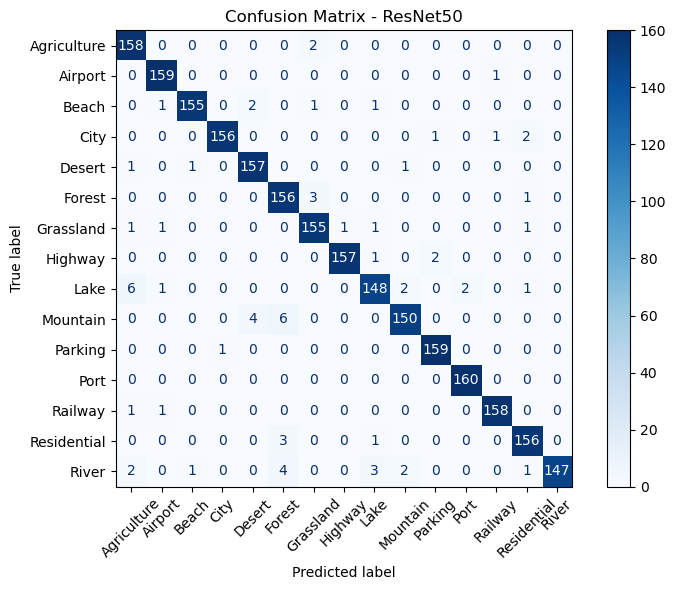

In [132]:
# Only run after final epoch - ResNet50
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=image_datasets['test'].classes)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - ResNet50")
plt.tight_layout()
plt.show()

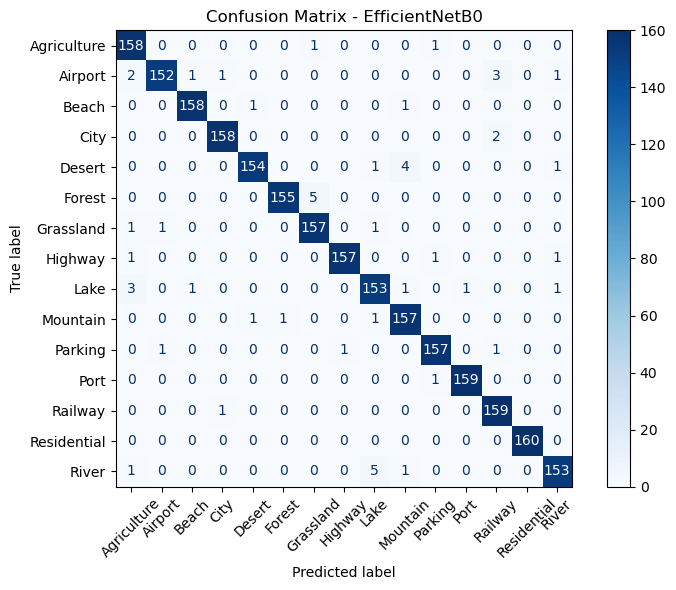

In [156]:
# Only run after final epoch - EfficientNetB0
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=image_datasets['test'].classes)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - EfficientNetB0")
plt.tight_layout()
plt.show()

In [134]:
# ==== Classification Report of ResNet50 ====
print("Classification Report of ResNet50:")
report = classification_report(all_labels, all_preds, target_names=image_datasets['test'].classes)
print(report)

Classification Report of ResNet50:
              precision    recall  f1-score   support

 Agriculture       0.93      0.99      0.96       160
     Airport       0.98      0.99      0.98       160
       Beach       0.99      0.97      0.98       160
        City       0.99      0.97      0.98       160
      Desert       0.96      0.98      0.97       160
      Forest       0.92      0.97      0.95       160
   Grassland       0.96      0.97      0.97       160
     Highway       0.99      0.98      0.99       160
        Lake       0.95      0.93      0.94       160
    Mountain       0.97      0.94      0.95       160
     Parking       0.98      0.99      0.99       160
        Port       0.99      1.00      0.99       160
     Railway       0.99      0.99      0.99       160
 Residential       0.96      0.97      0.97       160
       River       1.00      0.92      0.96       160

    accuracy                           0.97      2400
   macro avg       0.97      0.97      0.97  

In [158]:
# ==== Classification Report of EfficientNetB0 ====
print("Classification Report of EfficientNetB0:")
report = classification_report(all_labels, all_preds, target_names=image_datasets['test'].classes)
print(report)

Classification Report of EfficientNetB0:
              precision    recall  f1-score   support

 Agriculture       0.95      0.99      0.97       160
     Airport       0.99      0.95      0.97       160
       Beach       0.99      0.99      0.99       160
        City       0.99      0.99      0.99       160
      Desert       0.99      0.96      0.97       160
      Forest       0.99      0.97      0.98       160
   Grassland       0.96      0.98      0.97       160
     Highway       0.99      0.98      0.99       160
        Lake       0.95      0.96      0.95       160
    Mountain       0.96      0.98      0.97       160
     Parking       0.98      0.98      0.98       160
        Port       0.99      0.99      0.99       160
     Railway       0.96      0.99      0.98       160
 Residential       1.00      1.00      1.00       160
       River       0.97      0.96      0.97       160

    accuracy                           0.98      2400
   macro avg       0.98      0.98      

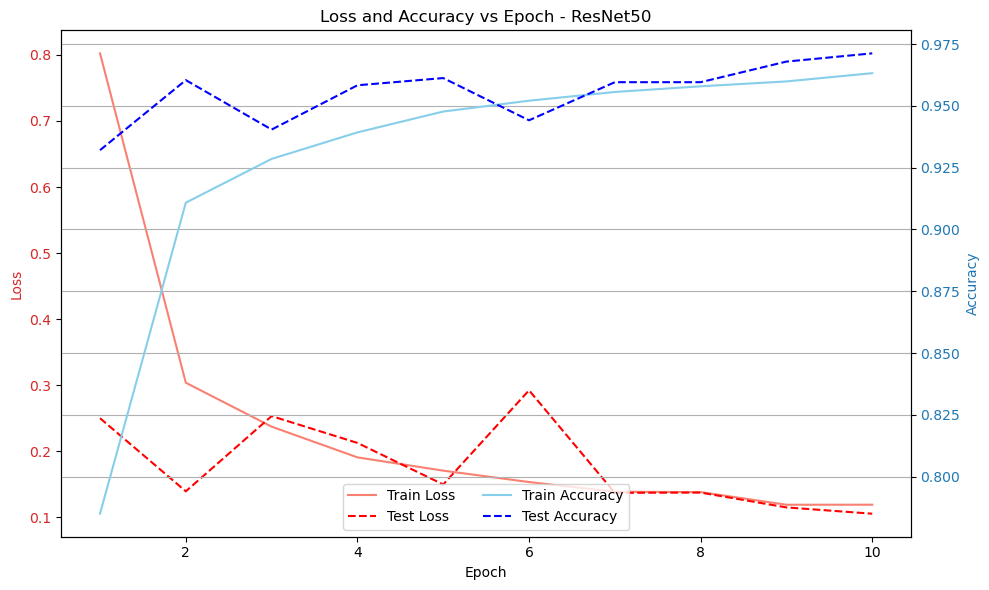

In [136]:
#Learning Curve of ResNet50
epochs = range(1, num_epochs + 1)
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, train_losses, label='Train Loss', color='salmon', linestyle='-')
ax1.plot(epochs, test_losses, label='Test Loss', color='red', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(epochs, train_accs, label='Train Accuracy', color='skyblue', linestyle='-')
ax2.plot(epochs, test_accs, label='Test Accuracy', color='blue', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower center', ncol=2)

plt.title('Loss and Accuracy vs Epoch - ResNet50')
plt.grid(True)
plt.tight_layout()
plt.show()

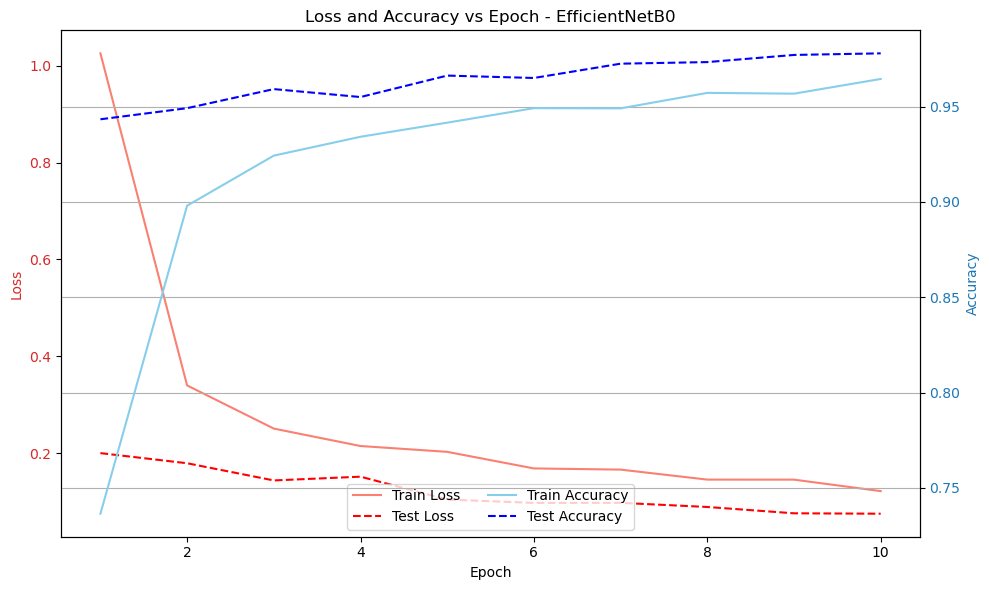

In [160]:
#Learning Curve of EfficientNetB0
epochs = range(1, num_epochs + 1)
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, train_losses, label='Train Loss', color='salmon', linestyle='-')
ax1.plot(epochs, test_losses, label='Test Loss', color='red', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(epochs, train_accs, label='Train Accuracy', color='skyblue', linestyle='-')
ax2.plot(epochs, test_accs, label='Test Accuracy', color='blue', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower center', ncol=2)

plt.title('Loss and Accuracy vs Epoch - EfficientNetB0')
plt.grid(True)
plt.tight_layout()
plt.show()